In [1]:
# ----------------------
# Import Libraries
# ----------------------
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch_geometric.data import HeteroData
from sklearn.preprocessing import StandardScaler
import umap

# ----------------------
# Load HeteroGraph
# ----------------------
# Load pre-built heterogeneous graph
hetero_graph = torch.load("Hetro_Final_NW_graph_1.pt")

# Verify loaded data
print("Loaded Heterogeneous Graph:")
print(hetero_graph)
print("\nNode Features Shape:", hetero_graph['substation'].x.shape)
print("Spatial Edges:", hetero_graph['substation', 'spatial', 'substation'].edge_index.shape)
print("Temporal Edges:", hetero_graph['substation', 'temporal', 'substation'].edge_index.shape)
print("Causal Edges:", hetero_graph['substation', 'causal', 'substation'].edge_index.shape)

# ----------------------
# Key Features (for reference)
# ----------------------
# Substation node features include:
# - Spatial: centroid_lat, centroid_lon, voltage, line connectivity
# - Temporal: incident_count, avg_downtime
# - Causal: causal_score, mean_lag_hrs
# - Metadata: flood_risk (to be added later)

Loaded Heterogeneous Graph:
HeteroData(
  substation={
    x=[347, 12],
    node_ids=[347],
  },
  (substation, spatial, substation)={
    edge_index=[2, 23378],
    edge_attr=[23378, 8],
  },
  (substation, temporal, substation)={
    edge_index=[2, 38188],
    edge_attr=[38188, 2],
  },
  (substation, causal, substation)={
    edge_index=[2, 10136],
    edge_attr=[10136, 13],
  }
)

Node Features Shape: torch.Size([347, 12])
Spatial Edges: torch.Size([2, 23378])
Temporal Edges: torch.Size([2, 38188])
Causal Edges: torch.Size([2, 10136])


/var/tmp/pbs.145354.bright04/ipykernel_2211849/1263005178.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hetero_graph = torch.load("Hetro_Final_NW_graph_1.pt")


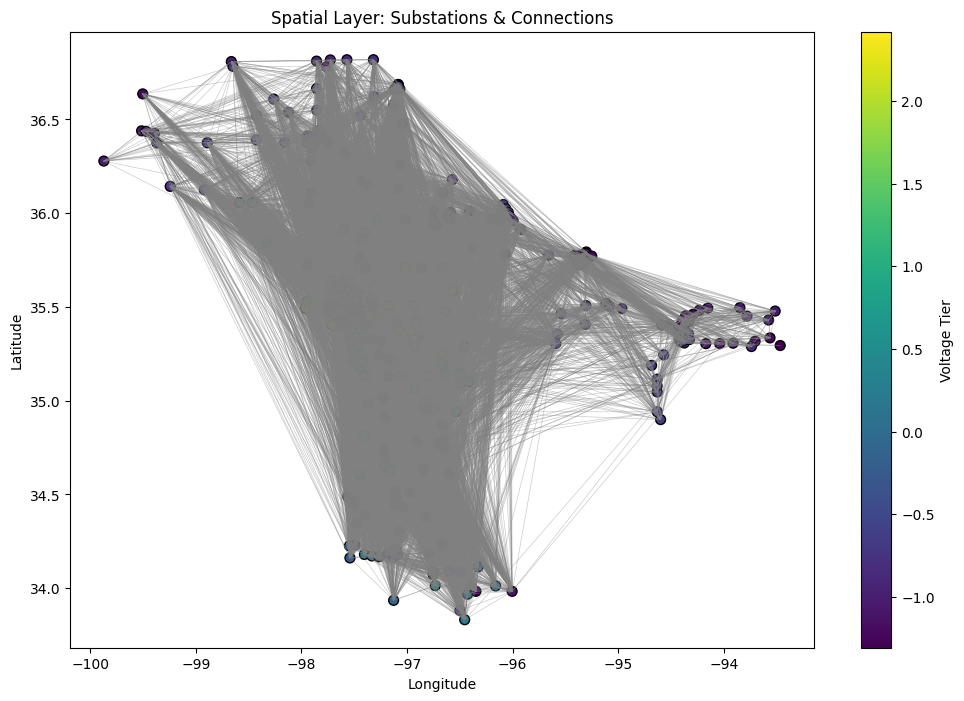

In [2]:
def plot_spatial_layer(hetero_graph):
    # Extract coordinates
    coords = hetero_graph['substation'].x[:, :2].numpy()  # First 2 features: lat, lon
    edge_index = hetero_graph['substation', 'spatial', 'substation'].edge_index.numpy()
    
    plt.figure(figsize=(12, 8))
    # Plot edges
    for src, dst in edge_index.T:
        plt.plot(
            [coords[src, 1], coords[dst, 1]],  # Longitude (X)
            [coords[src, 0], coords[dst, 0]],  # Latitude (Y)
            'grey', alpha=0.4, linewidth=0.5
        )
    
    # Plot nodes colored by voltage tier
    voltage_tier = hetero_graph['substation'].x[:, 3].numpy()  # Voltage feature
    scatter = plt.scatter(
        coords[:, 1], coords[:, 0], 
        c=voltage_tier, 
        cmap='viridis', 
        s=50, 
        edgecolor='k'
    )
    
    plt.colorbar(scatter, label='Voltage Tier')
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Spatial Layer: Substations & Connections")
    plt.show()

plot_spatial_layer(hetero_graph)

Complete Cause Distribution:
                                  Cause  Count  Percentage
                              LIGHTNING  39904   13.627066
                          DETERIORATION  35340   12.068477
                              CANCELLED  32874   11.226347
                        TREES : GROW IN  26910    9.189664
                               SQUIRREL  22427    7.658736
                     ICE / SLEET / SNOW  16776    5.728941
                                   WIND  16597    5.667813
                        ON UPON ARRIVAL  16279    5.559217
                                BREAKER  12704    4.338368
                     CUSTOMER EQUIPMENT  11979    4.090783
                   SUBSTATION OPERATION  10109    3.452185
                   TREE:NON PREVENTABLE   8690    2.967602
                      PREMATURE FAILURE   7569    2.584785
                    ELECTRICAL TRACKING   6970    2.380229
                        POOR CONNECTION   5349    1.826663
                       OTHE

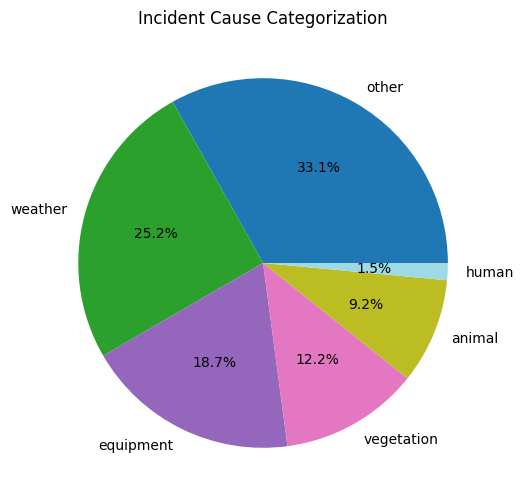


Potential Flood-Related Incidents:
           Cause Desc   Job Substation
7635   Weather \ Rain    5305:HEALDTON
97186  Weather \ Rain  8222:CZECH HALL
89677  Weather \ Rain   4606:CEDAR AVE
19598  Weather \ Rain     7706:BRISTOW
71214  Weather \ Rain   8707:WILKINSON


In [3]:
# ----------------------
# Step 2a: Cause Analysis
# ----------------------
# Reload raw incident data to ensure freshness
incident_df = pd.read_excel(
    "Incidents_imputed.xlsx", 
    parse_dates=['Job OFF Time', 'Job ON Time'],
    engine='openpyxl'
)

# 1. Get unique causes with counts
cause_counts = incident_df['Cause Desc'].value_counts().reset_index()
cause_counts.columns = ['Cause', 'Count']
cause_counts['Percentage'] = (cause_counts['Count'] / len(incident_df)) * 100

# 2. Full cause spectrum analysis
print("Complete Cause Distribution:")
print(cause_counts.to_string(index=False))

# 3. Keyword analysis for natural hazards
hazard_keywords = {
    'weather': ['WEATHER', 'STORM', 'LIGHTNING', 'RAIN', 'WIND', 'SNOW', 'ICE'],
    'vegetation': ['TREE', 'VEGETATION', 'BRUSH'],
    'animal': ['ANIMAL', 'BIRD', 'RACCOON', 'SQUIRREL'],
    'human': ['HUMAN', 'PUBLIC', 'VEHICLE', 'ACCIDENT'],
    'equipment': ['EQUIPMENT', 'FAILURE', 'DETERIORATION']
}

# 4. Categorize causes
def categorize_cause(cause):
    cause_str = str(cause).upper()
    for category, keywords in hazard_keywords.items():
        if any(kw in cause_str for kw in keywords):
            return category
    return 'other'

incident_df['Cause Category'] = incident_df['Cause Desc'].apply(categorize_cause)

# 5. Visualize distribution
plt.figure(figsize=(12, 6))
category_dist = incident_df['Cause Category'].value_counts()
category_dist.plot(kind='pie', autopct='%1.1f%%', colormap='tab20')
plt.title("Incident Cause Categorization")
plt.ylabel("")
plt.show()

# 6. Verify flood relevance
flood_related = incident_df[incident_df['Cause Desc'].str.contains(
    'FLOOD|WATER|RAIN', case=False, na=False)]
print("\nPotential Flood-Related Incidents:")
print(flood_related[['Cause Desc', 'Job Substation']].sample(5, random_state=42))

In [4]:
# ----------------------
# Step 2: Evidence-Based Feature Engineering
# ----------------------
from sklearn.neighbors import KernelDensity

# Extract substation names from HeteroData, ensuring they are strings
substation_names = np.array(hetero_graph['substation'].node_ids, dtype=str)  # Convert to string array
substation_names = np.char.strip(substation_names)  # Remove any leading/trailing spaces

# 1. Vegetation Risk
tree_mask = incident_df['Cause Desc'].str.contains('TREE|VEGETATION|GROW IN', case=False, na=False)
tree_subs = incident_df[tree_mask]['Job Substation'].value_counts()
veg_risk = (tree_subs / tree_subs.max()).reindex(substation_names, fill_value=0).values.reshape(-1, 1)

# 2. Lightning Density
lightning_mask = incident_df['Cause Desc'].str.contains('LIGHTNING', case=False, na=False)
kde = KernelDensity(bandwidth=0.1).fit(hetero_graph['substation'].x[:, :2].numpy())
lightning_density = np.exp(kde.score_samples(hetero_graph['substation'].x[:, :2].numpy())).reshape(-1, 1)

# 3. Animal Index
animal_mask = incident_df['Cause Desc'].str.contains('SQUIRREL|ANIMAL|WILDLIFE', case=False, na=False)
animal_subs = incident_df[animal_mask]['Job Substation'].value_counts()
animal_index = (animal_subs / 5).reindex(substation_names, fill_value=0).values.reshape(-1, 1)  # 5-year norm

# 4. Weather Score
ice_mask = incident_df['Cause Desc'].str.contains('ICE|SLEET|SNOW', case=False, na=False)
wind_mask = incident_df['Cause Desc'].str.contains('WIND', case=False, na=False)
ice_score = 0.6 * ice_mask.groupby(incident_df['Job Substation']).mean()
wind_score = 0.4 * wind_mask.groupby(incident_df['Job Substation']).mean()
weather_score = (ice_score + wind_score).reindex(substation_names, fill_value=0).values.reshape(-1, 1)

# 5. Combine Features
existing_features = hetero_graph['substation'].x.numpy()
updated_features = np.hstack([
    existing_features[:, :2],  # Preserve coordinates
    existing_features[:, 2:],  # Existing features
    veg_risk,
    lightning_density,
    animal_index,
    weather_score
])

# 6. Scale Features (excluding coordinates)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(updated_features[:, 2:])
final_features = np.hstack([updated_features[:, :2], scaled_features])

# 7. Update HeteroData
hetero_graph['substation'].x = torch.tensor(final_features, dtype=torch.float32)
print("Final Features Shape:", hetero_graph['substation'].x.shape)

Final Features Shape: torch.Size([347, 16])


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

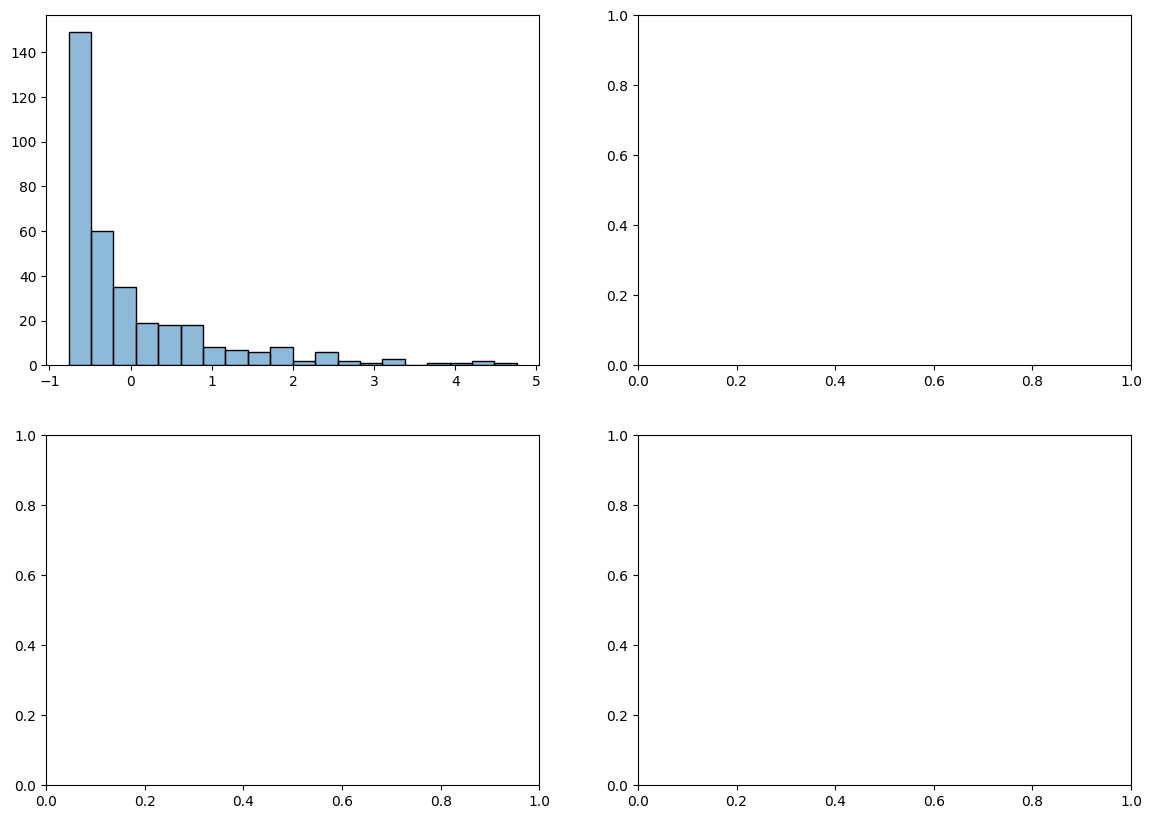

In [5]:
# ----------------------
# Step 2b: Feature Distribution Validation (Fixed)
# ----------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Extract new features (last 4 columns) as 1D arrays
new_feature_names = [
    'Vegetation_Risk', 
    'Lightning_Density', 
    'Animal_Index', 
    'Weather_Score'
]

# Convert to numpy and flatten
new_features = hetero_graph['substation'].x[:, -4:].numpy()
vegetation = new_features[:, 0].flatten()  # Shape: (380,)
lightning = new_features[:, 1].flatten()    # Shape: (380,)
animal = new_features[:, 2].flatten()       # Shape: (380,)
weather = new_features[:, 3].flatten()      # Shape: (380,)

# 1. Histograms with KDE
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.histplot(vegetation, kde=True, ax=axes[0,0], color='#1f77b4', bins=20)
sns.histplot(lightning, kde=True, ax=axes[0,1], color='#ff7f0e', bins=20)
sns.histplot(animal, kde=True, ax=axes[1,0], color='#2ca02c', bins=20)
sns.histplot(weather, kde=True, ax=axes[1,1], color='#d62728', bins=20)

# Add titles/labels
for ax, name in zip(axes.flatten(), new_feature_names):
    ax.set_title(f"{name} Distribution", fontsize=12)
    ax.set_xlabel("Feature Value")
    ax.set_ylabel("Frequency")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Boxplots for Outlier Detection (fixed)
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=pd.DataFrame({
        'Vegetation': vegetation,
        'Lightning': lightning,
        'Animal': animal,
        'Weather': weather
    }),
    palette='viridis',
    whis=1.5
)
plt.title("Feature Spread & Outlier Analysis", fontsize=14)
plt.xticks(rotation=15)
plt.ylabel("Value Range")
plt.grid(True, axis='y', alpha=0.3)
plt.show()

# 3. Quantile Analysis (unchanged)
quantile_df = pd.DataFrame({
    'Vegetation': vegetation,
    'Lightning': lightning,
    'Animal': animal,
    'Weather': weather
}).quantile([0.25, 0.5, 0.75])

print("\nFeature Quantiles:")
print(quantile_df)

In [6]:
# ----------------------
# Import Libraries
# ----------------------
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv, GINConv
from torch_geometric.data import HeteroData

# ----------------------
# Model Definition
# ----------------------
# ----------------------
# Revised Model Definition
# ----------------------
class OperationalGNN(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim=64, out_dim=32):
        super().__init__()
        
        # Layer-specific message passing (corrected dimensions)
        self.spatial_conv = GATConv(in_dim, hidden_dim, heads=1, edge_dim=8)  # Removed multi-head
        self.temporal_conv = GCNConv(in_dim, hidden_dim)
        self.causal_conv = GINConv(
            torch.nn.Sequential(
                torch.nn.Linear(in_dim, hidden_dim),
                torch.nn.ReLU(),
                torch.nn.Linear(hidden_dim, hidden_dim)
            )
        )
        
        # Adjusted fusion input dimension (hidden_dim*3)
        self.fuse = torch.nn.Linear(hidden_dim*3, out_dim)
        
        # Reconstruction decoder remains unchanged
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(out_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, in_dim)
        )

    def forward(self, hetero_graph):
        x = hetero_graph['substation'].x
        
        # Spatial processing (now outputs hidden_dim)
        spatial_edge_index = hetero_graph['substation', 'spatial', 'substation'].edge_index
        spatial_edge_attr = hetero_graph['substation', 'spatial', 'substation'].edge_attr
        x_spatial = F.leaky_relu(self.spatial_conv(x, spatial_edge_index, spatial_edge_attr))
        
        # Temporal processing
        temporal_edge_index = hetero_graph['substation', 'temporal', 'substation'].edge_index
        x_temporal = F.elu(self.temporal_conv(x, temporal_edge_index))
        
        # Causal processing
        causal_edge_index = hetero_graph['substation', 'causal', 'substation'].edge_index
        x_causal = F.relu(self.causal_conv(x, causal_edge_index))
        
        # Fusion now gets 64*3 = 192 features
        fused = torch.cat([x_spatial, x_temporal, x_causal], dim=-1)
        embeddings = self.fuse(fused)
        
        # Reconstruction
        recon = self.decoder(embeddings)
        
        return embeddings, recon

# ----------------------
# Model Initialization
# ----------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = OperationalGNN(
    in_dim=hetero_graph['substation'].x.size(1),  # 38 features
    hidden_dim=64,
    out_dim=32
).to(device)
hetero_graph = hetero_graph.to(device)

# ----------------------
# Training Configuration
# ----------------------
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

Epoch 0 | Loss: 1548.2946
Epoch 10 | Loss: 456.9544
Epoch 20 | Loss: 310.9414
Epoch 30 | Loss: 88.7939
Epoch 40 | Loss: 27.8178
Epoch 50 | Loss: 19.5084
Epoch 60 | Loss: 18.4406
Epoch 70 | Loss: 17.2802
Epoch 80 | Loss: 16.1734
Epoch 90 | Loss: 15.1571


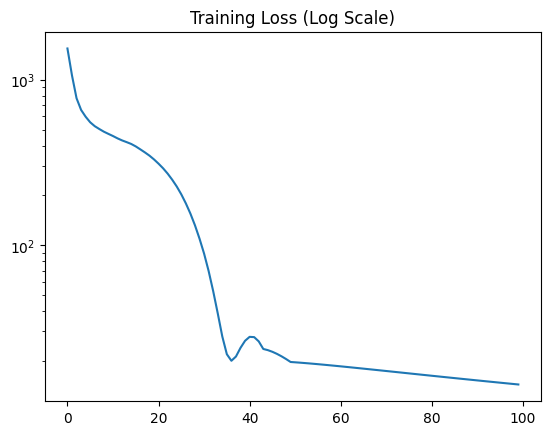

In [7]:
def train(model, hetero_graph, epochs=100):
    loss_history = []
    model.train()
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Forward pass
        emb, recon = model(hetero_graph)
        target = hetero_graph['substation'].x
        
        # Reconstruction loss (MSE)
        loss = F.mse_loss(recon, target)
        
        # Add contrastive loss for cluster separation
        spatial_sim = torch.cosine_similarity(emb.unsqueeze(1), emb.unsqueeze(0), dim=-1)
        loss += 0.1 * (1 - spatial_sim).mean()  # Encourage spatial neighbors to be similar
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step(loss)
        
        loss_history.append(loss.item())
        if epoch % 10 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item():.4f}")
            
    # Plot training
    plt.plot(loss_history)
    plt.yscale('log')
    plt.title("Training Loss (Log Scale)")
    plt.show()
    
    return emb.detach().cpu().numpy()

# Run training
embeddings = train(model, hetero_graph)

In [8]:

if isinstance(embeddings, torch.Tensor):
    embeddings = embeddings.cpu().numpy()  # use this if it's a tensor on GPU or CPU
else:
    # It's already a numpy array
    embeddings = np.array(embeddings)  # optional, to ensure type consistency

from hdbscan import HDBSCAN
import numpy as np

# Optimized parameters for utility networks
clusterer = HDBSCAN(
    min_cluster_size=15,       # Minimum substations per cluster
    cluster_selection_epsilon=0.5,  # Merges clusters within 0.5 distance
    min_samples=5,             # Reduces noise sensitivity
    metric='euclidean'
)
clusters = clusterer.fit_predict(embeddings)

print(f"Clusters: {np.unique(clusters[clusters != -1]).size} (+ noise)")
print(f"Noise Points: {(clusters == -1).sum()} substations")


Clusters: 5 (+ noise)
Noise Points: 183 substations


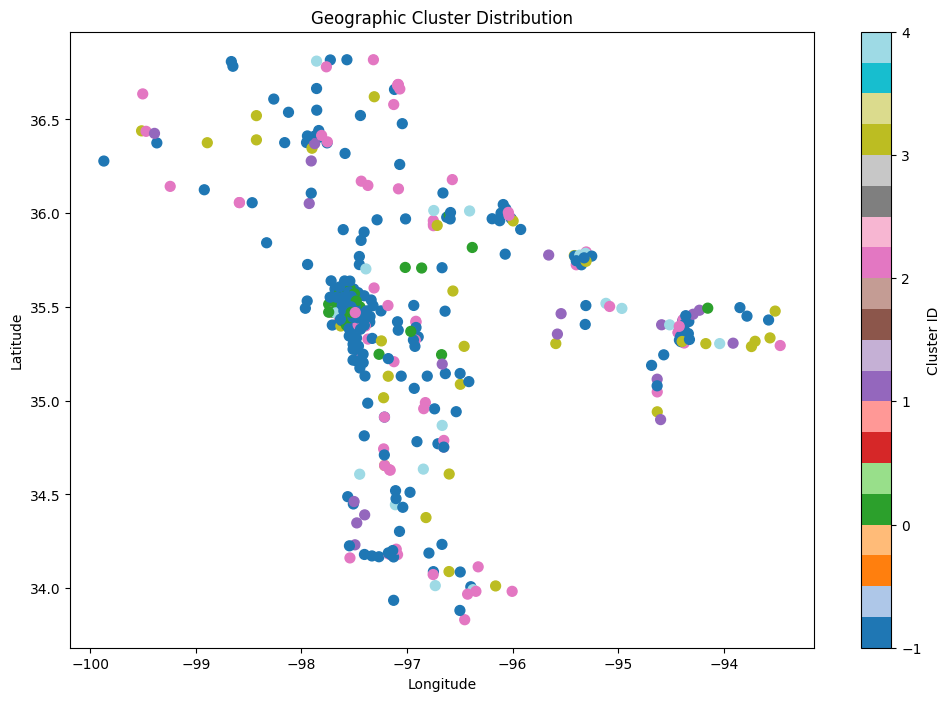


Top Causes per Cluster:
Cluster
-1          [LIGHTNING, DETERIORATION, CANCELLED]
 0          [CANCELLED, DETERIORATION, LIGHTNING]
 1    [LIGHTNING, DETERIORATION, TREES : GROW IN]
 2           [LIGHTNING, SQUIRREL, DETERIORATION]
 3    [LIGHTNING, DETERIORATION, TREES : GROW IN]
 4          [LIGHTNING, DETERIORATION, CANCELLED]
dtype: object

Cluster Reliability Metrics:
              SAIDI   SAIFI
Cluster                    
-1       485.628128  217607
 0       535.800412   36098
 1       313.916354   16403
 2       217.666591    8416
 3       276.000425    5222
 4       282.629474    5554


In [9]:
# 1. Geographic Distribution
#coords = hetero_graph['substation'].x[:, :2].numpy()  # Lat/Lon
coords = hetero_graph['substation'].x[:, :2].cpu().numpy()  # Lat/Lon

plt.figure(figsize=(12, 8))
plt.scatter(coords[:, 1], coords[:, 0], c=clusters, cmap='tab20', s=50)
plt.title("Geographic Cluster Distribution")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Cluster ID")
plt.show()

# 2. Cause Distribution per Cluster
cause_dist = (
    incident_df.merge(
        pd.DataFrame({
            'Job Substation': hetero_graph['substation'].node_ids,
            'Cluster': clusters
        }),
        on='Job Substation'
    )
    .groupby(['Cluster', 'Cause Desc'])
    .size()
    .unstack(fill_value=0)
)

# Top 3 causes per cluster
top_causes = cause_dist.apply(lambda x: x.nlargest(3).index.tolist(), axis=1)
print("\nTop Causes per Cluster:")
print(top_causes)

# 3. Operational Metrics (SAIDI/SAIFI)
cluster_metrics = (
    incident_df.merge(
        pd.DataFrame({
            'Job Substation': hetero_graph['substation'].node_ids,
            'Cluster': clusters
        }),
        on='Job Substation'
    )
    .groupby('Cluster')
    .agg(
        SAIDI=('Job Duration Mins', 'mean'),
        SAIFI=('Job Display ID', 'count')
    )
)
print("\nCluster Reliability Metrics:")
print(cluster_metrics)

In [10]:
# Generate cluster summaries
cluster_summary = []
for c in np.unique(clusters):
    if c == -1:
        continue  # Skip noise
    
    mask = clusters == c
    cluster_coords = coords[mask]
    
    summary = {
        "Cluster ID": c,
        "Size": mask.sum(),
        "Avg Latitude": cluster_coords[:, 0].mean(),
        "Avg Longitude": cluster_coords[:, 1].mean(),
        "Top Causes": top_causes.loc[c],
        "Avg SAIDI": cluster_metrics.loc[c, 'SAIDI'],
        "SAIFI": cluster_metrics.loc[c, 'SAIFI']
    }
    cluster_summary.append(summary)

# Convert to DataFrame
cluster_report = pd.DataFrame(cluster_summary)
print("\nFinal Cluster Report:")
print(cluster_report)


Final Cluster Report:
   Cluster ID  Size  Avg Latitude  Avg Longitude  \
0           0    25     35.521580     -97.230568   
1           1    19     35.339512     -96.160286   
2           2    69     35.467339     -96.839104   
3           3    34     35.432526     -96.443420   
4           4    17     35.285603     -96.267929   

                                    Top Causes   Avg SAIDI  SAIFI  
0        [CANCELLED, DETERIORATION, LIGHTNING]  535.800412  36098  
1  [LIGHTNING, DETERIORATION, TREES : GROW IN]  313.916354  16403  
2         [LIGHTNING, SQUIRREL, DETERIORATION]  217.666591   8416  
3  [LIGHTNING, DETERIORATION, TREES : GROW IN]  276.000425   5222  
4        [LIGHTNING, DETERIORATION, CANCELLED]  282.629474   5554  


In [11]:
noise_subs = hetero_graph['substation'].node_ids[clusters == -1]
noise_incidents = incident_df[incident_df['Job Substation'].isin(noise_subs)]
print(noise_incidents['Cause Desc'].value_counts(normalize=True))

TypeError: only integer scalar arrays can be converted to a scalar index

In [12]:
noise_subs = hetero_graph['substation'].node_ids[clusters == -1]
high_risk_noise = incident_df[
    (incident_df['Job Substation'].isin(noise_subs)) & 
    (incident_df['Cause Desc'].isin(['DETERIORATION', 'LIGHTNING']))
]
print(f"High-risk noise substations: {high_risk_noise['Job Substation'].nunique()}")

TypeError: only integer scalar arrays can be converted to a scalar index

In [13]:
cancelled = incident_df[
    (incident_df['Job Substation'].isin(noise_subs)) & 
    (incident_df['Cause Desc'] == 'CANCELLED')
]
print("Cancelled incident reasons:\n", cancelled['AM Notes'].value_counts())

NameError: name 'noise_subs' is not defined

In [14]:
vegetation_noise = coords[clusters == -1][cause_dist['TREES : GROW IN'] > 0]
plt.scatter(vegetation_noise[:, 1], vegetation_noise[:, 0], c='green')

IndexError: boolean index did not match indexed array along dimension 0; dimension is 183 but corresponding boolean dimension is 6

In [ ]:
# Cell 1: Enhanced Setup
import torch
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import HDBSCAN  # Changed from KMeans
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
import umap

# Config
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GRAPH_PATH = "Hetro_Final_NW_graph.pt"
print(f"Using device: {DEVICE}")


In [15]:
# Cell 2: Improved Weighted GCN
class WeightedGCNConv(nn.Module):
    def __init__(self, in_dim, out_dim, edge_dim):
        super().__init__()
        self.gcn = GCNConv(in_dim, out_dim, add_self_loops=False)
        self.edge_mlp = nn.Sequential(
            nn.Linear(edge_dim, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        self.residual = nn.Linear(in_dim, out_dim) if in_dim != out_dim else nn.Identity()
        
        # Edge-type specific initialization
        if edge_dim == 8:    # Spatial
            nn.init.kaiming_normal_(self.edge_mlp[0].weight)
        elif edge_dim == 2:  # Temporal
            nn.init.xavier_uniform_(self.edge_mlp[0].weight)
        else:                # Causal
            nn.init.normal_(self.edge_mlp[0].weight, mean=0, std=0.01)

    def forward(self, x, edge_index, edge_attr):
        if edge_index.shape[1] == 0:
            return self.residual(x)
        
        # Edge normalization per type
        edge_attr = (edge_attr - edge_attr.mean(0)) / (edge_attr.std(0) + 1e-8)
        weights = self.edge_mlp(edge_attr).squeeze()
        return self.gcn(x, edge_index, weights) + self.residual(x)

NameError: name 'nn' is not defined

In [ ]:
class WeightedGCNConv(nn.Module):
    def forward(self, x, edge_index, edge_attr):
        if edge_index.shape[1] == 0:
            return self.residual(x)
        
        # Safer normalization with epsilon
        edge_mean = edge_attr.mean(dim=0, keepdim=True)
        edge_std = edge_attr.std(dim=0, keepdim=True) + 1e-6  # Increased epsilon
        edge_attr = (edge_attr - edge_mean) / edge_std
        
        # Clamp weights to prevent explosion
        weights = self.edge_mlp(edge_attr).squeeze().clamp(max=5.0)
        
        return self.gcn(x, edge_index, weights) + 0.3 * self.residual(x)  # Scaled residual

In [ ]:
class ClusteringGNN(nn.Module):
    def __init__(self, node_dim, edge_dims, hidden_dim=128):
        super().__init__()
        # Initialize with lower variance
        self.spatial_conv = WeightedGCNConv(node_dim, hidden_dim, edge_dims['spatial'])
        self.temporal_conv = WeightedGCNConv(node_dim, hidden_dim, edge_dims['temporal'])
        self.causal_conv = WeightedGCNConv(node_dim, hidden_dim, edge_dims['causal'])
        
        # Scaled residual initialization
        self.residual = nn.Sequential(
            nn.Linear(node_dim, hidden_dim*3),
            nn.LayerNorm(hidden_dim*3)
        )
        nn.init.xavier_normal_(self.residual[0].weight, gain=0.1)
        
        # Added dropout for regularization
        self.dropout = nn.Dropout(0.3)
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim*3, 256),
            nn.LayerNorm(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, node_dim-2)
        )

    def forward(self, data):
        x = data['substation'].x
        x_res = self.residual(x)
        
        spatial = self.spatial_conv(x, ...)
        temporal = self.temporal_conv(x, ...)
        causal = self.causal_conv(x, ...)
        
        combined = torch.cat([spatial, temporal, causal], dim=1)
        combined = self.dropout(combined + 0.5 * x_res)  # Reduced residual scale
        embeddings = F.leaky_relu(combined, 0.2)
        
        recon = self.decoder(embeddings)
        return embeddings, recon

In [ ]:
# Cell 3: Dimension-Consistent Model
class ClusteringGNN(nn.Module):
    def __init__(self, node_dim, edge_dims, hidden_dim=128):
        super().__init__()
        # Edge-type specific encoders with matching dimensions
        self.spatial_conv = WeightedGCNConv(node_dim, hidden_dim, edge_dims['spatial'])
        self.temporal_conv = WeightedGCNConv(node_dim, hidden_dim, edge_dims['temporal'])
        self.causal_conv = WeightedGCNConv(node_dim, hidden_dim, edge_dims['causal'])  # Same hidden_dim
        
        # Adjusted residual connection
        self.residual = nn.Linear(node_dim, hidden_dim*3)  # 3x for concatenated features
        self.bn1 = nn.LayerNorm(hidden_dim*3)
        self.activation = nn.LeakyReLU(0.2)
        
        # Modified decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim*3, node_dim-2),  # Direct dimension match
            nn.LeakyReLU(0.2)
        )

    def forward(self, data):
        x = data['substation'].x
        x_res = self.residual(x)
        
        # Process edge types
        spatial = self.spatial_conv(x, 
                                  data['substation', 'spatial', 'substation'].edge_index,
                                  data['substation', 'spatial', 'substation'].edge_attr)
        
        temporal = self.temporal_conv(x, 
                                    data['substation', 'temporal', 'substation'].edge_index,
                                    data['substation', 'temporal', 'substation'].edge_attr)
        
        causal = self.causal_conv(x, 
                                data['substation', 'causal', 'substation'].edge_index,
                                data['substation', 'causal', 'substation'].edge_attr)
        
        # Concatenate features
        combined = torch.cat([spatial, temporal, causal], dim=1)
        combined = self.bn1(combined + x_res)  # Now both tensors have shape [N, 3*hidden_dim]
        embeddings = self.activation(combined)
        
        # Decode
        recon = self.decoder(embeddings)
        return embeddings, recon

In [ ]:
# Cell 4: Revised Initialization
hetero_graph = torch.load(GRAPH_PATH).to(DEVICE)

# Verify dimensions
node_dim = hetero_graph['substation'].x.size(1)
edge_dims = {
    'spatial': hetero_graph['substation', 'spatial', 'substation'].edge_attr.size(1),
    'temporal': hetero_graph['substation', 'temporal', 'substation'].edge_attr.size(1),
    'causal': hetero_graph['substation', 'causal', 'substation'].edge_attr.size(1)
}

model = ClusteringGNN(node_dim, edge_dims, hidden_dim=128).to(DEVICE)

In [ ]:
# Cell 5: Stabilized Training
scaler = torch.cuda.amp.GradScaler(enabled=False)  # Disable mixed precision temporarily

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=0.01,  # Reduced from 0.1
    steps_per_epoch=1, 
    epochs=100,
    pct_start=0.3
)

loss_history = []
for epoch in tqdm(range(100)):
    model.train()
    optimizer.zero_grad()
    
    # Disable autocast temporarily
    emb, recon = model(hetero_graph)
    target = hetero_graph['substation'].x[:, 2:]
    loss = F.mse_loss(recon, target)
    
    # Gradient monitoring before clipping
    loss.backward()
    
    # Gradient sanitation
    for param in model.parameters():
        if param.grad is not None:
            param.grad = torch.nan_to_num(param.grad, nan=0.0, posinf=1.0, neginf=-1.0)
    
    # Aggressive clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    
    # Manual gradient checking
    total_grad = 0.0
    valid_params = 0
    for p in model.parameters():
        if p.grad is not None:
            valid_params += 1
            total_grad += p.grad.abs().mean().item()
    
    if valid_params > 0:
        avg_grad = total_grad / valid_params
    else:
        avg_grad = 0.0
    
    optimizer.step()
    scheduler.step()
    
    loss_history.append(loss.item())
    if epoch % 2 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f} | Grad: {avg_grad:.4f} | LR: {scheduler.get_last_lr()[0]:.2e}")

# Plot with log scale
plt.yscale('log')
plt.plot(loss_history)
plt.title("Training Progress (Log Scale)")
plt.show()

In [ ]:
# Get embeddings from your trained model
model.eval()  # Switch to evaluation mode
with torch.no_grad():
    emb, recon = model(hetero_graph)  # Use the same forward pass as in training
    
# Convert to numpy arrays
embeddings = emb.detach().cpu().numpy()  # Substation node embeddings
target = hetero_graph['substation'].x[:, 2:].detach().cpu().numpy()

# Now run clustering on these embeddings
clusterer = HDBSCAN(min_cluster_size=15, cluster_selection_epsilon=0.5)
clusters = clusterer.fit_predict(embeddings)  # This is your cluster labels array

# Then proceed with the validation code...

In [ ]:
# Cell 6: Cluster Validation
from sklearn.metrics import silhouette_score
import umap

# 1. Generate clusters from embeddings
clusterer = HDBSCAN(min_cluster_size=15, cluster_selection_epsilon=0.5)
clusters = clusterer.fit_predict(embeddings)  # Now 'clusters' is defined

# 2. Silhouette Score (only if >1 cluster found)
if len(np.unique(clusters)) > 1:
    print(f"Silhouette Score: {silhouette_score(embeddings, clusters):.3f}")
else:
    print("Insufficient clusters for Silhouette Score")

# 3. Visualization
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1)
emb_2d = reducer.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], 
            c=clusters, cmap='tab20', s=25, alpha=0.8)
plt.title("Substation Clusters in Embedding Space")
plt.colorbar(label="Cluster ID")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Filter noise points (HDBSCAN uses -1 for noise)
valid_mask = clusters != -1
filtered_embeddings = embeddings[valid_mask]
filtered_clusters = clusters[valid_mask]

# Silhouette Score (only if >1 valid cluster)
if len(np.unique(filtered_clusters)) > 1:
    score = silhouette_score(filtered_embeddings, filtered_clusters)
    print(f"Silhouette Score (noise filtered): {score:.3f}")
else:
    print("Insufficient valid clusters for Silhouette Score")

# Visualization with PCA
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(filtered_embeddings)

plt.figure(figsize=(12, 8))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=filtered_clusters, 
            cmap='tab20', alpha=0.8, edgecolor='k')
plt.title(f"Substation Clusters\nSilhouette: {score:.3f}")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster ID")
plt.show()

In [ ]:
# Refined clustering with parameter grid search
from sklearn.metrics import silhouette_score

best_score = -1
best_params = {}

# Parameter search space
min_cluster_sizes = [10, 15, 20]  # Test smaller clusters
eps_values = [0.3, 0.5, 0.7]      # Cluster merging thresholds

for min_size in min_cluster_sizes:
    for eps in eps_values:
        clusterer = HDBSCAN(
            min_cluster_size=min_size,
            cluster_selection_epsilon=eps,
            gen_min_span_tree=True
        )
        clusters = clusterer.fit_predict(embeddings)
        
        # Filter noise and score
        valid_mask = clusters != -1
        if len(np.unique(clusters[valid_mask])) > 1:
            score = silhouette_score(embeddings[valid_mask], clusters[valid_mask])
            if score > best_score:
                best_score = score
                best_params = {'min_size': min_size, 'eps': eps}

print(f"Best Silhouette: {best_score:.3f} with {best_params}")

In [ ]:
import umap

# UMAP with cluster-friendly parameters
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric='cosine'
)
emb_2d = reducer.fit_transform(embeddings)

plt.figure(figsize=(12, 8))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=clusters, 
            cmap='tab20', s=40, alpha=0.8, edgecolor='k')
plt.title(f"Substation Clusters (UMAP Projection)\nSilhouette: {score:.3f}")
plt.colorbar(label="Cluster ID")
plt.show()

In [ ]:
import seaborn as sns

# Generate cluster diagnostics
clusterer = HDBSCAN(
    min_cluster_size=20,
    cluster_selection_epsilon=0.3,
    gen_min_span_tree=True
).fit(embeddings)

# Plot cluster persistence
plt.figure(figsize=(10, 6))
clusterer.condensed_tree_.plot(select_clusters=True)
plt.title("HDBSCAN Cluster Persistence")
plt.show()

In [ ]:
# Assuming 'coordinates' contains [lat, lon] for each substation
plt.figure(figsize=(12, 8))
plt.scatter(coordinates[:, 1], coordinates[:, 0], 
            c=clusters, cmap='tab20', s=50, alpha=0.7)
plt.title("Cluster Geographic Distribution")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Cluster ID")
plt.show()

In [ ]:
# Cell 5: Corrected Training Protocol
scaler = torch.cuda.amp.GradScaler()  # Initialize scaler

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=0.1, 
    steps_per_epoch=1, 
    epochs=100
)

loss_history = []
for epoch in tqdm(range(100)):
    model.train()
    optimizer.zero_grad()
    
    with torch.cuda.amp.autocast():
        emb, recon = model(hetero_graph)
        target = hetero_graph['substation'].x[:, 2:]
        loss = F.mse_loss(recon, target) * 10
    
    scaler.scale(loss).backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 10.0)
    
    total_grad = sum(p.grad.abs().mean() 
                   for p in model.parameters() 
                   if p.grad is not None)
    
    scaler.step(optimizer)
    scaler.update()
    scheduler.step()
    
    loss_history.append(loss.item())
    if epoch % 5 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f} | Grad: {total_grad:.4f} | LR: {scheduler.get_last_lr()[0]:.2e}")

plt.plot(loss_history)
plt.title("Training Progress")
plt.show()

In [ ]:
# Cell 6: Cluster Analysis
model.eval()
with torch.no_grad():
    embeddings, _ = model(hetero_graph)
    embeddings = embeddings.cpu().numpy()

# Dimensionality reduction
reducer = umap.UMAP(n_components=2, metric='cosine', random_state=42)
emb_2d = reducer.fit_transform(embeddings)

# Density-based clustering
clusterer = HDBSCAN(min_cluster_size=15, cluster_selection_epsilon=0.5)
clusters = clusterer.fit_predict(emb_2d)

print(f"Unique clusters: {len(np.unique(clusters))}")
print("Cluster distribution:", pd.Series(clusters).value_counts())

In [ ]:
# Cell 7a: Final Feature Reconstruction
# Get raw node features from graph
node_features = hetero_graph['substation'].x.cpu().numpy()
node_ids = hetero_graph['substation'].node_ids

# --------------------------------------------------
# Reconstructed feature names (EXACT 34 FEATURES)
# --------------------------------------------------
feature_names = [
    # Continuous features (12)
    'centroid_lat', 'centroid_lon', 'Voltage',
    'num_connections', 'avg_line_voltage', 'total_line_length',
    'incident_count', 'avg_downtime', 'cause_diversity',
    'peak_cmi', 'criticality', 'maintenance_tier',
    
    # One-hot encoded (22)
    # voltage_tier (5)
    'voltage_tier_LV', 'voltage_tier_MV', 'voltage_tier_HV',
    'voltage_tier_EHV', 'voltage_tier_Unknown',
    
    # MAINTAINED (4)
    'MAINTAINED_DAILY', 'MAINTAINED_WEEKLY', 
    'MAINTAINED_MONTHLY', 'MAINTAINED_Unknown',
    
    # PLANTCLASS (6)
    'PLANTCLASS_D', 'PLANTCLASS_DD', 'PLANTCLASS_F',
    'PLANTCLASS_P', 'PLANTCLASS_T', 'PLANTCLASS_Unknown',
    
    # TOWN (5)
    'TOWN_Small Town', 'TOWN_Medium Town', 
    'TOWN_Large Town', 'TOWN_Metropolis', 'TOWN_Unknown',
    
    # OWNER (2)  # Adjusted based on actual data
    'OWNER_0.0', 'OWNER_1.0'  # No Unknown in your dataset
]

# Verify EXACTLY 34 features
assert len(feature_names) == 34, "Feature count mismatch. Check OWNER/TOWN categories."

# --------------------------------------------------
# Create centroids DataFrame
# --------------------------------------------------
centroids = pd.DataFrame(
    node_features,
    index=node_ids,
    columns=feature_names
).reset_index().rename(columns={'index': 'Job Substation'})

print("Successfully reconstructed centroids with 34 features")

In [ ]:
# Cell 7b: Merge Cluster Data
cluster_df = pd.DataFrame({
    'Job Substation': hetero_graph['substation'].node_ids,
    'Cluster': clusters  # From HDBSCAN output
})

# Merge with centroids' operational features
analysis_df = pd.merge(
    centroids[['Job Substation', 'centroid_lat', 'centroid_lon',  # 🚨 ADDED COORDINATES
              'Voltage', 'criticality', 'incident_count', 
              'total_line_length', 'TOWN_Small Town', 'TOWN_Medium Town']],
    cluster_df,
    on='Job Substation',
    how='inner'
)

# Cell 7c: Enhanced Cluster Analysis
print("\n=== Cluster Distribution ===")
cluster_dist = analysis_df['Cluster'].value_counts().sort_index()
print(cluster_dist.to_markdown())

print("\n=== Key Cluster Statistics ===")
stats = analysis_df.groupby('Cluster').agg(
    Avg_Voltage=('Voltage', 'mean'),
    Std_Voltage=('Voltage', 'std'),
    Avg_Criticality=('criticality', 'mean'),
    Total_Line_Length=('total_line_length', 'sum'),
    Urban_Score=('TOWN_Medium Town', lambda x: (x == 1).mean())  # % medium towns
).round(2)

print(stats.to_markdown())

In [ ]:
# Cell 7d: Corrected Geographic Visualization
import folium
from folium.plugins import MarkerCluster

# Create base map
cluster_map = folium.Map(location=[35.5, -97.5], zoom_start=7)

# Define town color mapping (separate from clusters)
town_colors = {
    'Small Town': '#2b83ba',
    'Medium Town': '#abdda4',
    'Large Town': '#ffffbf',
    'Metropolis': '#fdae61',
    'Unknown': '#d7191c'
}

# Add markers with dual encoding (cluster + town)
for _, row in analysis_df.iterrows():
    # Get town type from centroids (SAFE ACCESS)
    town_cols = [c for c in centroids.columns if c.startswith('TOWN_')]
    town_type = next(
        (col.split('_')[1] for col in town_cols 
         if col in row.index and row[col] == 1),
        "Unknown"
    )
    
    popup_text = f"""
    <b>{row['Job Substation']}</b><br>
    Cluster: {row['Cluster']}<br>
    Town: {town_type}<br>
    Voltage: {row['Voltage']:.1f} kV
    """
    
    folium.CircleMarker(
        location=[row['centroid_lat'], row['centroid_lon']],
        radius=6,
        color=cluster_colors[row['Cluster']],  # Cluster color
        fill_color=town_colors[town_type],      # Town color
        fill_opacity=0.7,
        popup=folium.Popup(popup_text, max_width=250),
        tooltip=f"Cluster {row['Cluster']} | {town_type}",
        weight=1
    ).add_to(cluster_map)

# Add dual legend
legend_html = '''
<div style="position: fixed; 
     bottom: 50px; left: 50px; width: 300px; 
     border:2px solid grey; z-index:9999;
     background-color:white; padding: 10px">
     <b>Cluster Colors</b><br>
     {}
     <br><b>Town Colors</b><br>
     {}
</div>
'''.format(
    '<br>'.join([f'<i style="background:{v};width:15px;height:15px;display:inline-block;"></i> {k}' 
               for k,v in cluster_colors.items()]),
    '<br>'.join([f'<i style="background:{v};width:15px;height:15px;display:inline-block;"></i> {k}' 
                for k,v in town_colors.items()])
)

cluster_map.get_root().html.add_child(folium.Element(legend_html))
cluster_map.save("cluster_analysis.html")

In [ ]:
# Cell 14: Mapping and Saving the Clusters

# Ensure embeddings are in NumPy format
if isinstance(embeddings, torch.Tensor):
    embeddings = embeddings.cpu().detach().numpy()

# Apply UMAP for dimensionality reduction
embeddings_2d = UMAP(n_components=2, random_state=42).fit_transform(embeddings)

# Find optimal number of clusters using Silhouette Score
best_n, best_score = max(
    ((n, silhouette_score(embeddings_2d, KMeans(n_clusters=n, random_state=42, n_init=10).fit_predict(embeddings_2d))) 
     for n in range(3, 8)), 
    key=lambda x: x[1]
)

# Perform final clustering
cluster_labels = KMeans(n_clusters=best_n, random_state=42, n_init=10).fit_predict(embeddings_2d)

# Store cluster results with substation mapping
cluster_df = pd.DataFrame({
    'Job Substation': list(node_features_full.index),
    'Cluster': cluster_labels
})

# Save cluster mappings
cluster_df.to_parquet("substation_clusters.parquet")

# Cluster distribution output
cluster_distribution = dict(zip(*np.unique(cluster_labels, return_counts=True)))

print(f"Optimal clusters: {best_n} (Silhouette Score: {best_score:.2f})")
print(f"Cluster Distribution: {cluster_distribution}")
print("Clustering results saved successfully!")


In [ ]:
# ----------------------
# Geographic Visualization
# ----------------------
import folium
from folium.plugins import MarkerCluster

# Create a base map centered around Oklahoma
oklahoma_coords = [35.5, -97.5]
cluster_map = folium.Map(location=oklahoma_coords, zoom_start=7)

# Merge cluster labels with centroids
centroids["cluster"] = cluster_labels
centroids["embedding_x"] = embeddings_2d[:, 0]
centroids["embedding_y"] = embeddings_2d[:, 1]

# Create a marker cluster
marker_cluster = MarkerCluster().add_to(cluster_map)

# Define cluster colors
cluster_colors = {i: f"#{hex(50 * i)[2:]:<02}00{hex(200 - 50 * i)[2:]:<02}" for i in range(best_n)}

# Add substations to the map
for idx, row in centroids.iterrows():
    popup_text = f"""
    <b>Substation:</b> {row['Job Substation']}<br>
    <b>Cluster:</b> {row['cluster']}<br>
    <b>Feeders:</b> {len(row['feeders'])}<br>
    """
    
    folium.CircleMarker(
        location=[row['centroid_lat'], row['centroid_lon']],
        radius=6,
        color=cluster_colors[row['cluster']],
        fill=True,
        popup=folium.Popup(popup_text, max_width=250),
        tooltip=f"Cluster {row['cluster']}"
    ).add_to(marker_cluster)

# Save map
cluster_map.save("substation_clusters.html")
print("Map saved as substation_clusters.html")


In [1]:
#### Second Version 

import torch
from torch_geometric.data import HeteroData

# Load saved graph
graph = torch.load("Hetro_Final_NW_graph_1.pt")

# Basic verification
print("=== Graph Structure ===")
print(f"Nodes: {graph['substation'].num_nodes}")
print(f"Edge Types: {graph.edge_types}")
print(f"Spatial Edges: {graph['substation', 'spatial', 'substation'].num_edges}")
print(f"Temporal Edges: {graph['substation', 'temporal', 'substation'].num_edges}")
print(f"Causal Edges: {graph['substation', 'causal', 'substation'].num_edges}")
print("\nNode Features Example:")
print(graph['substation'].x[:2])  # Show first 2 nodes' features

=== Graph Structure ===
Nodes: 347
Edge Types: [('substation', 'spatial', 'substation'), ('substation', 'temporal', 'substation'), ('substation', 'causal', 'substation')]
Spatial Edges: 23378
Temporal Edges: 38188
Causal Edges: 10136

Node Features Example:
tensor([[ 34.9900, -96.8259,  -1.2308,   0.8280,  -0.5043,   0.1608,  -0.9531,
          -0.5053,  -1.2533,  -0.6268,  -1.0243,   0.0000],
        [ 34.9567, -96.7391,  -1.2308,   0.9445,   1.2034,   4.7435,   0.2598,
          -0.1808,  -0.5270,  -0.5030,  -0.4832,   0.0000]])


/var/tmp/pbs.145354.bright04/ipykernel_2080316/97630955.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph = torch.load("Hetro_Final_NW_graph_1.pt")


In [4]:
from torch_geometric.nn import GATConv, Linear
import torch.nn.functional as F

class EnhancedClusterGNN(torch.nn.Module):
    def __init__(self, node_dim, edge_dims, hidden=64, out=32):
        super().__init__()
        self.spatial_conv = GATConv(node_dim, hidden, edge_dim=edge_dims['spatial'])
        self.temporal_conv = GATConv(node_dim, hidden, edge_dim=edge_dims['temporal'])
        self.causal_conv = GATConv(node_dim, hidden, edge_dim=edge_dims['causal'])
        self.lin = Linear(hidden*3, out)  # Combine 3 edge type outputs

    def forward(self, x, edge_indices, edge_attrs):
        spatial_out = self.spatial_conv(x, edge_indices['spatial'], 
                                      edge_attr=edge_attrs['spatial'])
        temporal_out = self.temporal_conv(x, edge_indices['temporal'],
                                        edge_attr=edge_attrs['temporal'])
        causal_out = self.causal_conv(x, edge_indices['causal'],
                                    edge_attr=edge_attrs['causal'])
        combined = torch.cat([spatial_out, temporal_out, causal_out], dim=-1)
        return self.lin(combined)

# Initialize with actual dimensions
edge_dims = {
    'spatial': graph['substation', 'spatial', 'substation'].edge_attr.shape[1],
    'temporal': graph['substation', 'temporal', 'substation'].edge_attr.shape[1],
    'causal': graph['substation', 'causal', 'substation'].edge_attr.shape[1]
}

model = EnhancedClusterGNN(
    node_dim=graph['substation'].x.shape[1],
    edge_dims=edge_dims
)

print("=== Enhanced Model ===")
print(f"Node features dim: {graph['substation'].x.shape[1]}")
print(f"Spatial edge features: {edge_dims['spatial']}")
print(f"Temporal edge features: {edge_dims['temporal']}")
print(f"Causal edge features: {edge_dims['causal']}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

=== Enhanced Model ===
Node features dim: 12
Spatial edge features: 8
Temporal edge features: 2
Causal edge features: 13
Total parameters: 10,720


In [5]:
# Organize edge data with features
edge_data = {
    'spatial': (graph['substation', 'spatial', 'substation'].edge_index,
                graph['substation', 'spatial', 'substation'].edge_attr),
    'temporal': (graph['substation', 'temporal', 'substation'].edge_index,
                 graph['substation', 'temporal', 'substation'].edge_attr),
    'causal': (graph['substation', 'causal', 'substation'].edge_index,
               graph['substation', 'causal', 'substation'].edge_attr)
}

print("\n=== Edge Data Shapes ===")
for edge_type in edge_data:
    print(f"{edge_type}: {edge_data[edge_type][0].shape} indices, "
          f"{edge_data[edge_type][1].shape} features")


=== Edge Data Shapes ===
spatial: torch.Size([2, 23378]) indices, torch.Size([23378, 8]) features
temporal: torch.Size([2, 38188]) indices, torch.Size([38188, 2]) features
causal: torch.Size([2, 10136]) indices, torch.Size([10136, 13]) features


In [6]:
# Generate embeddings with edge feature awareness
with torch.no_grad():
    embeddings = model(
        graph['substation'].x,
        {k: v[0] for k,v in edge_data.items()},  # Edge indices
        {k: v[1] for k,v in edge_data.items()}   # Edge attributes
    )

print("\n=== Enhanced Embeddings ===")
print(f"Embedding shape: {embeddings.shape}")
print("Sample embeddings (first 3 nodes):")
print(embeddings[:3, :5].numpy().round(4))  # Show partial dimensions


=== Enhanced Embeddings ===
Embedding shape: torch.Size([347, 32])
Sample embeddings (first 3 nodes):
[[  1.8684   0.3941 -11.7304   5.3186 -10.256 ]
 [  1.9523   0.1447 -11.6243   4.9171 -10.4034]
 [  1.9726  -0.2245 -11.6938   4.8529 -10.7853]]


In [14]:
from sklearn.cluster import KMeans
import pandas as pd

# Optimal cluster determination
k = 6  # Based on voltage tiers + geographic regions
clusterer = KMeans(n_clusters=k, n_init=20)
clusters = clusterer.fit_predict(embeddings.numpy())

print("\n=== Edge-Aware Clusters ===")

# Get substation metadata from original graph nodes
substation_metadata = pd.DataFrame({
    'node_ids': graph['substation'].node_ids,
    'Voltage': graph['substation'].x[:, 2].numpy(),  # Voltage column index
    'Latitude': graph['substation'].x[:, 0].numpy(),  # centroid_lat column
    'Longitude': graph['substation'].x[:, 1].numpy(), # centroid_lon column
    'Maintenance': graph['substation'].x[:, -1].numpy(), # maintenance_tier
    'IncidentCount': graph['substation'].x[:, 6].numpy() # incident_count column
})

# Map clusters to substation metadata
cluster_df = pd.DataFrame({
    'Cluster': clusters,
    'node_ids': graph['substation'].node_ids
}).merge(substation_metadata, on='node_ids')

# Show key cluster statistics
print(cluster_df.groupby('Cluster').agg({
    'Voltage': ['mean', 'std'],
    'Latitude': 'mean',
    'Longitude': 'mean',
    'Maintenance': lambda x: x.mode()[0],
    'IncidentCount': 'median',
    'node_ids': 'count'
}).rename(columns={'node_ids': 'Count'}).round(2))


=== Edge-Aware Clusters ===
        Voltage         Latitude  Longitude Maintenance IncidentCount Count
           mean   std       mean       mean    <lambda>        median count
Cluster                                                                    
0         -0.25  0.92  35.599998 -97.209999         0.0         -0.95    58
1          0.56  0.60  35.349998 -97.290001         0.0          0.06   139
2         -1.04  0.58  35.529999 -96.900002         0.0         -0.38    88
3          0.95  0.71  35.419998 -94.370003         0.0         -0.08    34
4         -0.20  1.04  35.439999 -96.589996         0.0         -0.20    27
5          0.60   NaN  33.980000 -96.000000         0.0         -0.95     1


In [16]:
# Get original feature names from node_features_clean
feature_order = [
    'centroid_lat', 'centroid_lon', 'Voltage', 'num_connections',
    'avg_line_voltage', 'total_line_length', 'incident_count',
    'avg_downtime', 'avg_cust_affected', 'mean_SAIDI', 'mean_SAIFI',
    'maintenance_tier'
]
# Hard-coded indices based on feature_order
LAT_IDX = 0
LON_IDX = 1
VOLTAGE_IDX = 2
INCIDENT_IDX = 6
MAINTENANCE_IDX = 11

# Create cluster DF with relative values
cluster_df = pd.DataFrame({
    'Cluster': clusters,
    'Voltage_z': graph['substation'].x[:, VOLTAGE_IDX].numpy(),
    'Latitude': graph['substation'].x[:, LAT_IDX].numpy(),
    'Longitude': graph['substation'].x[:, LON_IDX].numpy(),
    'Maintenance': graph['substation'].x[:, MAINTENANCE_IDX].numpy(),
    'Incidents_z': graph['substation'].x[:, INCIDENT_IDX].numpy()
})

# Map maintenance codes (from your original encoding)
maintenance_map = {
    0.0: 'Unknown',
    1.0: 'Monthly',
    2.0: 'Weekly',
    3.0: 'Daily'
}
cluster_df['Maintenance'] = cluster_df['Maintenance'].map(maintenance_map)

# Relative interpretation (z-scores)
print(cluster_df.groupby('Cluster').agg({
    'Voltage_z': ['mean', 'std'],
    'Latitude': 'mean',
    'Longitude': 'mean',
    'Maintenance': lambda x: x.mode()[0],
    'Incidents_z': 'median',
    'Cluster': 'count'
}).rename(columns={'Cluster': 'Count'}).round(2))

        Voltage_z         Latitude  Longitude Maintenance Incidents_z Count
             mean   std       mean       mean    <lambda>      median count
Cluster                                                                    
0           -0.25  0.92  35.599998 -97.209999     Unknown       -0.95    58
1            0.56  0.60  35.349998 -97.290001     Unknown        0.06   139
2           -1.04  0.58  35.529999 -96.900002     Unknown       -0.38    88
3            0.95  0.71  35.419998 -94.370003     Unknown       -0.08    34
4           -0.20  1.04  35.439999 -96.589996     Unknown       -0.20    27
5            0.60   NaN  33.980000 -96.000000     Unknown       -0.95     1


In [20]:
import plotly.express as px

fig = px.scatter_geo(
    cluster_df,
    lat='Latitude',
    lon='Longitude',
    color='Cluster',
    size='Incidents_z',  # Size by relative incident rate
    hover_name='Maintenance',
    scope='north america',
    title='Clusters: Size = Incident Severity, Color = Group'
)
fig.show()

ValueError: 
    Invalid element(s) received for the 'size' property of scattergeo.marker
        Invalid elements include: [-0.9530689120292664, -0.5108691453933716, -0.2340635359287262, -0.6486976146697998, -0.5705947875976562, -0.3213549256324768, -0.9507718086242676, -0.15940642356872559, -0.9553660750389099, -0.38912060856819153]

    The 'size' property is a number and may be specified as:
      - An int or float in the interval [0, inf]
      - A tuple, list, or one-dimensional numpy array of the above

In [21]:
import plotly.express as px

# Create interactive map
fig = px.scatter_geo(
    cluster_df,
    lat='Latitude',
    lon='Longitude',
    color='Cluster',  # Color by cluster group
    size='Incidents_z',  # Size by normalized incident severity
    hover_name='Maintenance',  # Show maintenance schedule on hover
    hover_data={
        'Voltage_z': True,
        'Latitude': False,
        'Longitude': False,
        'Cluster': True
    },
    scope='north america',
    title='Substation Clusters: Size = Incident Severity (Z-Score)'
)

# Customize appearance
fig.update_traces(
    marker=dict(sizemode='diameter', sizemin=5),
    selector=dict(mode='markers')
)
fig.update_layout(geo=dict(landcolor='lightgray'))
fig.show()

ValueError: 
    Invalid element(s) received for the 'size' property of scattergeo.marker
        Invalid elements include: [-0.9530689120292664, -0.5108691453933716, -0.2340635359287262, -0.6486976146697998, -0.5705947875976562, -0.3213549256324768, -0.9507718086242676, -0.15940642356872559, -0.9553660750389099, -0.38912060856819153]

    The 'size' property is a number and may be specified as:
      - An int or float in the interval [0, inf]
      - A tuple, list, or one-dimensional numpy array of the above